In [12]:
import pandas as pd
import numpy as np
import random
from uuid import uuid4
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt
from tqdm import tqdm

In [13]:
def create_snapshots():
    snapshots = {}

    for i in range(5):
        posts = {j + 1: str(uuid4()) for j in range(10)}
        snapshots[str(uuid4())] = posts
    return snapshots


snapshots = create_snapshots()

In [15]:
def rotate_list_randomly(lst):
    if not lst:
        return lst
    n = len(lst)

    # Choose random number of rotations between 1 and n-1
    k = random.randint(1, n - 1)

    # Randomly decide direction: True for right, False for left
    right = random.choice([True, False])

    if right:
        rotated = lst[-k:] + lst[:-k]  # Rotate right
    else:
        rotated = lst[k:] + lst[:k]  # Rotate left

    return rotated


def fake_participant_data(snapshots=snapshots):

    participant_id = str(uuid4())

    # Which snapshots are they looking at?
    selected_snapshots = random.sample(list(snapshots.keys()), k=3)

    shown_proof = random.choice([True, False])

    # Pull out num_selected posts, with lower indices more likely.
    weights = (
        np.linspace(5, 1, 10) if shown_proof else np.linspace(10, 1, 10)
    )  # Higher weight for lower indices
    weights /= weights.sum()  # Normalize to sum to 1

    selections = []
    ratings = []

    for snapshot in selected_snapshots:

        # Get the posts in the correct order.
        posts = [snapshots[snapshot][i + 1] for i in range(10)]

        # Rotate the posts in this snapshot.
        posts = rotate_list_randomly(posts)

        # How many posts did they select?
        num_selected = random.choice([1, 2, 3])

        selected_indices = np.random.choice(
            range(10), size=num_selected, replace=False, p=weights
        )

        selections += [
            {
                "participant_id": participant_id,
                "rank": int(i) + 1,
                "snapshot_id": snapshot,
                "post_id": posts[int(i)],
                "shown_proof": shown_proof,
                "selected": True,
            }
            for i in selected_indices
        ]

        selections += [
            {
                "participant_id": participant_id,
                "rank": int(i) + 1,
                "snapshot_id": snapshot,
                "post_id": posts[int(i)],
                "shown_proof": shown_proof,
                "selected": False,
            }
            for i in range(10)
            if i not in selected_indices
        ]

    selections_df = pd.DataFrame(selections).set_index(["snapshot_id", "post_id"])

    for snapshot in selected_snapshots:

        # Get the selected post IDs.
        selected_posts = (
            selections_df.query("snapshot_id == @snapshot and selected == True")
            .reset_index()["post_id"]
            .values.tolist()
        )

        # Get the unselected post IDs.
        unselected_posts = (
            selections_df.query("snapshot_id == @snapshot and selected == False")
            .sample(3)
            .reset_index()["post_id"]
            .values.tolist()
        )

        for post in selected_posts:
            for perception in ["relevance", "trustworthiness", "content_quality"]:
                ratings.append(
                    {
                        "participant_id": participant_id,
                        "snapshot_id": snapshot,
                        "post_id": post,
                        "selected": True,
                        "rank": int(
                            selections_df.query(
                                "snapshot_id == @snapshot and post_id == @post"
                            )["rank"].values[0]
                        ),
                        "shown_proof": shown_proof,
                        "perception": perception,
                        "rating": max(
                            round(
                                random.randint(1, 5)
                                + (0 if shown_proof and random.random() > 0.2 else 1)
                                + 2
                            ),
                            5,
                        ),
                    }
                )

        for post in unselected_posts:
            for perception in ["relevance", "trustworthiness", "content_quality"]:
                ratings.append(
                    {
                        "participant_id": participant_id,
                        "snapshot_id": snapshot,
                        "post_id": post,
                        "selected": False,
                        "rank": int(
                            selections_df.query(
                                "snapshot_id == @snapshot and post_id == @post"
                            )["rank"].values[0]
                        ),
                        "shown_proof": shown_proof,
                        "perception": perception,
                        "rating": random.randint(1, 5),
                    }
                )

    return selections, ratings


selections, ratings = fake_participant_data()

In [16]:
num_participants = 200

selections, ratings = [], []

for _ in tqdm(range(num_participants)):

    _selections, _ratings = fake_participant_data()
    selections += _selections
    ratings += _ratings

selections_df = pd.DataFrame(selections).set_index(["snapshot_id", "post_id"])
ratings_df = pd.DataFrame(ratings).set_index(["snapshot_id", "post_id"])

100%|██████████| 200/200 [00:04<00:00, 44.63it/s]


In [17]:
# How many participants saw each snapshot?
selections_df.groupby("snapshot_id")["participant_id"].nunique()

snapshot_id
1f725867-0718-4c2a-bc17-dc73e6cf43c3    121
4fdb2d83-54cc-4fbf-85bb-49b02d7bcc71    125
67d63ec7-78e6-4d8f-8101-8469ac1f9e00    119
ba7adffb-c71b-4959-b642-3fa6cb47245a    116
df4c1747-cfae-4ee0-81e0-a32c6ca83d5a    119
Name: participant_id, dtype: int64

In [18]:
selections_df.query("selected").groupby("rank").size()

rank
1     229
2     196
3     158
4     132
5     117
6     119
7      95
8      68
9      72
10     32
dtype: int64

---

## H2 selection modeling, because it's easier.


In [32]:
h2_model = bmb.Model(
    formula="selected ~ shown_proof * C(rank) + (1 | participant_id) + (1 | snapshot_id) + (1 | post_id)",
    data=selections_df.reset_index(),
    family="bernoulli",
)

h2_results = h2_model.fit(target_accept=0.99)

Modeling the probability that selected==1
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, shown_proof, C(rank), shown_proof:C(rank), 1|participant_id_sigma, 1|participant_id_offset, 1|snapshot_id_sigma, 1|snapshot_id_offset, 1|post_id_sigma, 1|post_id_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.


In [2]:
np.exp(0.11)

np.float64(1.1162780704588713)

In [33]:
az.summary(h2_results).head(30)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.672,0.128,-0.907,-0.424,0.003,0.002,1458.0,2677.0,1.0
shown_proof,-0.053,0.172,-0.388,0.250,0.005,0.002,1182.0,2215.0,1.0
C(rank)[2],0.110,0.174,-0.216,0.430,0.004,0.002,1846.0,2930.0,1.0
C(rank)[3],-0.089,0.178,-0.423,0.244,0.004,0.002,2026.0,2876.0,1.0
C(rank)[4],-0.451,0.183,-0.805,-0.113,0.004,0.003,2157.0,2359.0,1.0
C(rank)[5],-0.505,0.184,-0.856,-0.172,0.004,0.003,1990.0,2613.0,1.0
C(rank)[6],-0.900,0.198,-1.265,-0.515,0.004,0.003,2328.0,3203.0,1.0
C(rank)[7],-1.054,0.206,-1.428,-0.648,0.004,0.003,2383.0,2347.0,1.0
C(rank)[8],-1.391,0.224,-1.799,-0.969,0.005,0.003,2456.0,3058.0,1.0
C(rank)[9],-1.747,0.243,-2.177,-1.263,0.004,0.003,2927.0,3139.0,1.0


---


In [19]:
ratings_df["rating"] = pd.Categorical(ratings_df["rating"], ordered=True)

In [25]:
model = bmb.Model(
    formula="rating ~ shown_proof * C(rank) + selected + (1 | participant_id) + (1 | snapshot_id) + (1 | post_id)",
    data=ratings_df.query("perception == 'relevance'").reset_index(),
    family="cumulative",
)

results = model.fit(target_accept=0.95)

/Users/jackie/Desktop/Files/ranking-study/.venv/lib/python3.13/site-packages/bambi/formula.py:111: UserWarning: The intercept is omitted in ordinal families
  warnings.warn("The intercept is omitted in ordinal families")
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rating_threshold, shown_proof, C(rank), shown_proof:C(rank), selected, 1|participant_id_sigma, 1|participant_id_offset, 1|snapshot_id_sigma, 1|snapshot_id_offset, 1|post_id_sigma, 1|post_id_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 243 seconds.


In [26]:
az.summary(results).head(30)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
shown_proof,-0.485,0.192,-0.839,-0.121,0.005,0.003,1295.0,1964.0,1.0
C(rank)[2],-0.153,0.183,-0.505,0.189,0.004,0.002,2225.0,2962.0,1.0
C(rank)[3],-0.212,0.201,-0.584,0.160,0.004,0.003,2476.0,2685.0,1.0
C(rank)[4],-0.103,0.197,-0.471,0.274,0.004,0.003,2289.0,2901.0,1.0
C(rank)[5],-0.341,0.198,-0.720,0.024,0.004,0.003,2297.0,2687.0,1.0
C(rank)[6],-0.253,0.191,-0.600,0.109,0.004,0.003,2272.0,2857.0,1.0
C(rank)[7],-0.234,0.197,-0.607,0.130,0.004,0.003,2290.0,2938.0,1.0
C(rank)[8],-0.160,0.196,-0.515,0.211,0.004,0.003,2493.0,2843.0,1.0
C(rank)[9],-0.058,0.200,-0.438,0.307,0.004,0.003,2481.0,2952.0,1.0
C(rank)[10],-0.214,0.203,-0.608,0.160,0.004,0.003,2451.0,2760.0,1.0


Sampling: [1|participant_id_sigma, 1|post_id_sigma, 1|snapshot_id_sigma, C(rank), rating_threshold, shown_proof, shown_proof:C(rank)]


array([[<Axes: title={'center': 'rating_threshold\n0'}>,
        <Axes: title={'center': 'rating_threshold\n1'}>,
        <Axes: title={'center': 'rating_threshold\n2'}>,
        <Axes: title={'center': 'rating_threshold\n3'}>],
       [<Axes: title={'center': 'shown_proof'}>,
        <Axes: title={'center': 'C(rank)\n2'}>,
        <Axes: title={'center': 'C(rank)\n3'}>,
        <Axes: title={'center': 'C(rank)\n4'}>],
       [<Axes: title={'center': 'C(rank)\n5'}>,
        <Axes: title={'center': 'C(rank)\n6'}>,
        <Axes: title={'center': 'C(rank)\n7'}>,
        <Axes: title={'center': 'C(rank)\n8'}>],
       [<Axes: title={'center': 'C(rank)\n9'}>,
        <Axes: title={'center': 'C(rank)\n10'}>,
        <Axes: title={'center': 'shown_proof:C(rank)\n2'}>,
        <Axes: title={'center': 'shown_proof:C(rank)\n3'}>],
       [<Axes: title={'center': 'shown_proof:C(rank)\n4'}>,
        <Axes: title={'center': 'shown_proof:C(rank)\n5'}>,
        <Axes: title={'center': 'shown_proof:C

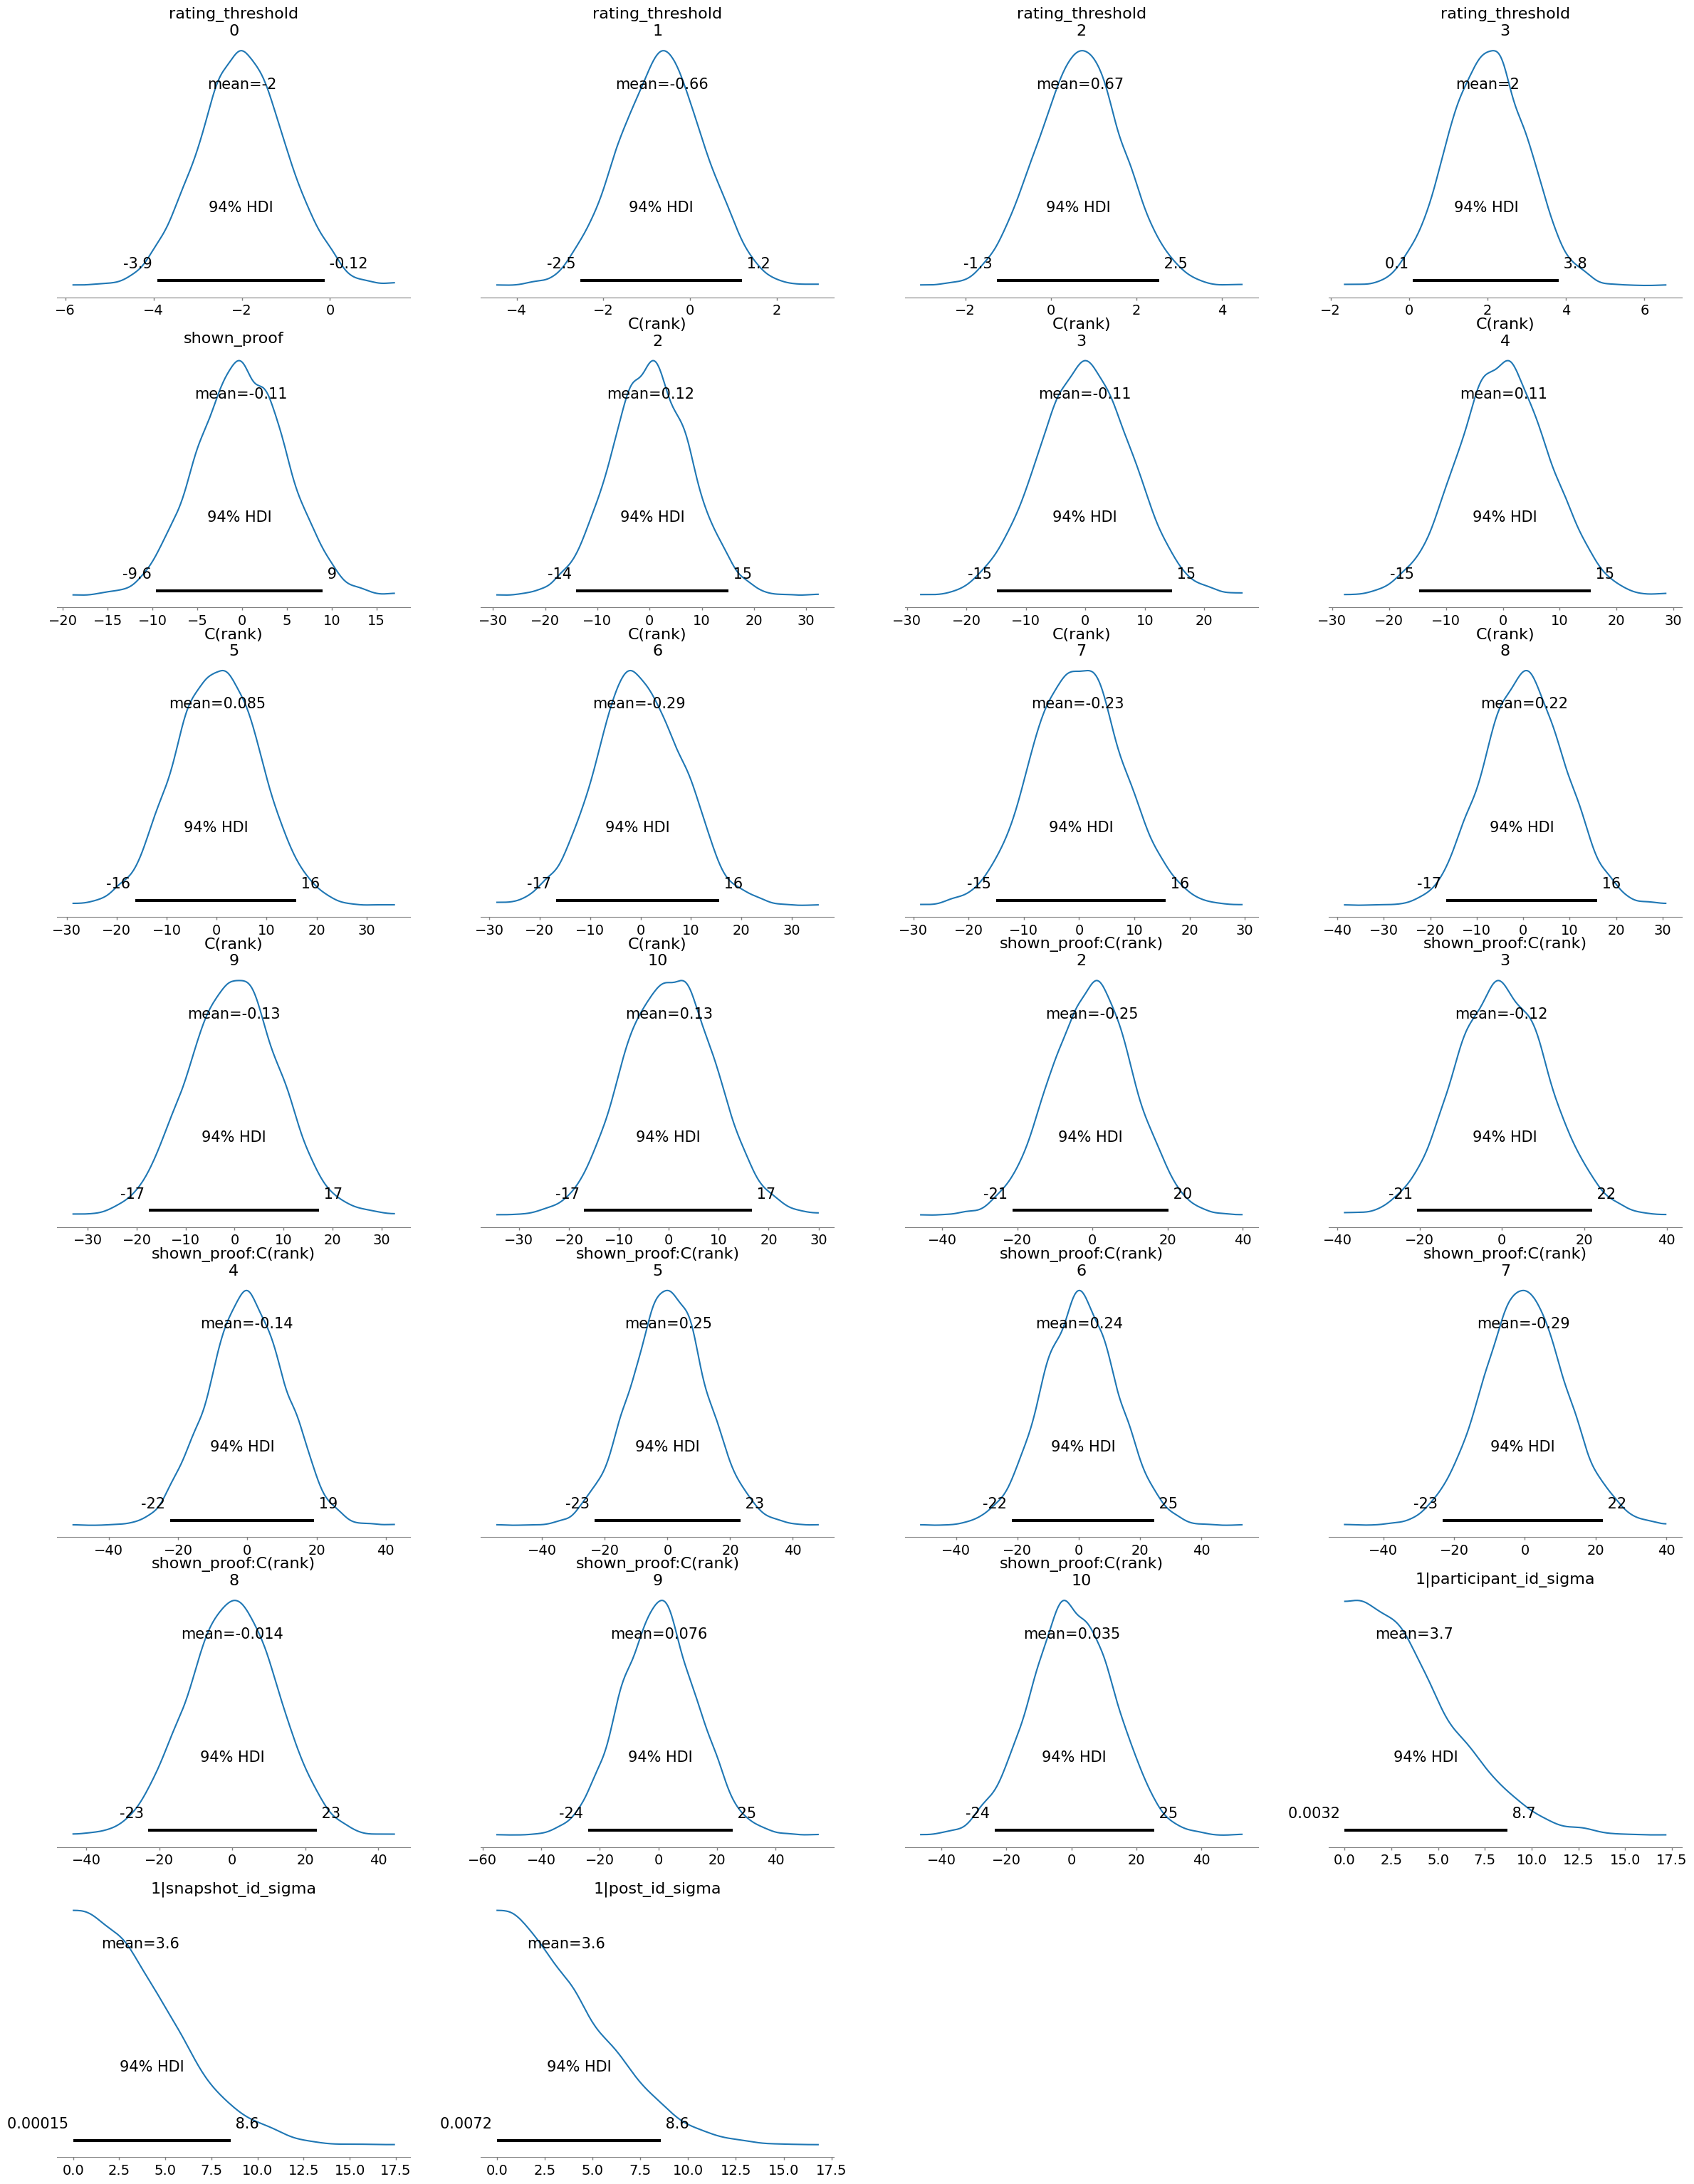

In [190]:
model.plot_priors()

array([[<Axes: title={'center': 'shown_proof'}>,
        <Axes: title={'center': 'shown_proof'}>],
       [<Axes: title={'center': 'rank'}>,
        <Axes: title={'center': 'rank'}>],
       [<Axes: title={'center': 'shown_proof:rank'}>,
        <Axes: title={'center': 'shown_proof:rank'}>],
       [<Axes: title={'center': 'rating_threshold'}>,
        <Axes: title={'center': 'rating_threshold'}>],
       [<Axes: title={'center': '1|participant_id_sigma'}>,
        <Axes: title={'center': '1|participant_id_sigma'}>],
       [<Axes: title={'center': '1|snapshot_id_sigma'}>,
        <Axes: title={'center': '1|snapshot_id_sigma'}>],
       [<Axes: title={'center': '1|post_id_sigma'}>,
        <Axes: title={'center': '1|post_id_sigma'}>],
       [<Axes: title={'center': '1|participant_id'}>,
        <Axes: title={'center': '1|participant_id'}>],
       [<Axes: title={'center': '1|snapshot_id'}>,
        <Axes: title={'center': '1|snapshot_id'}>],
       [<Axes: title={'center': '1|post_id'

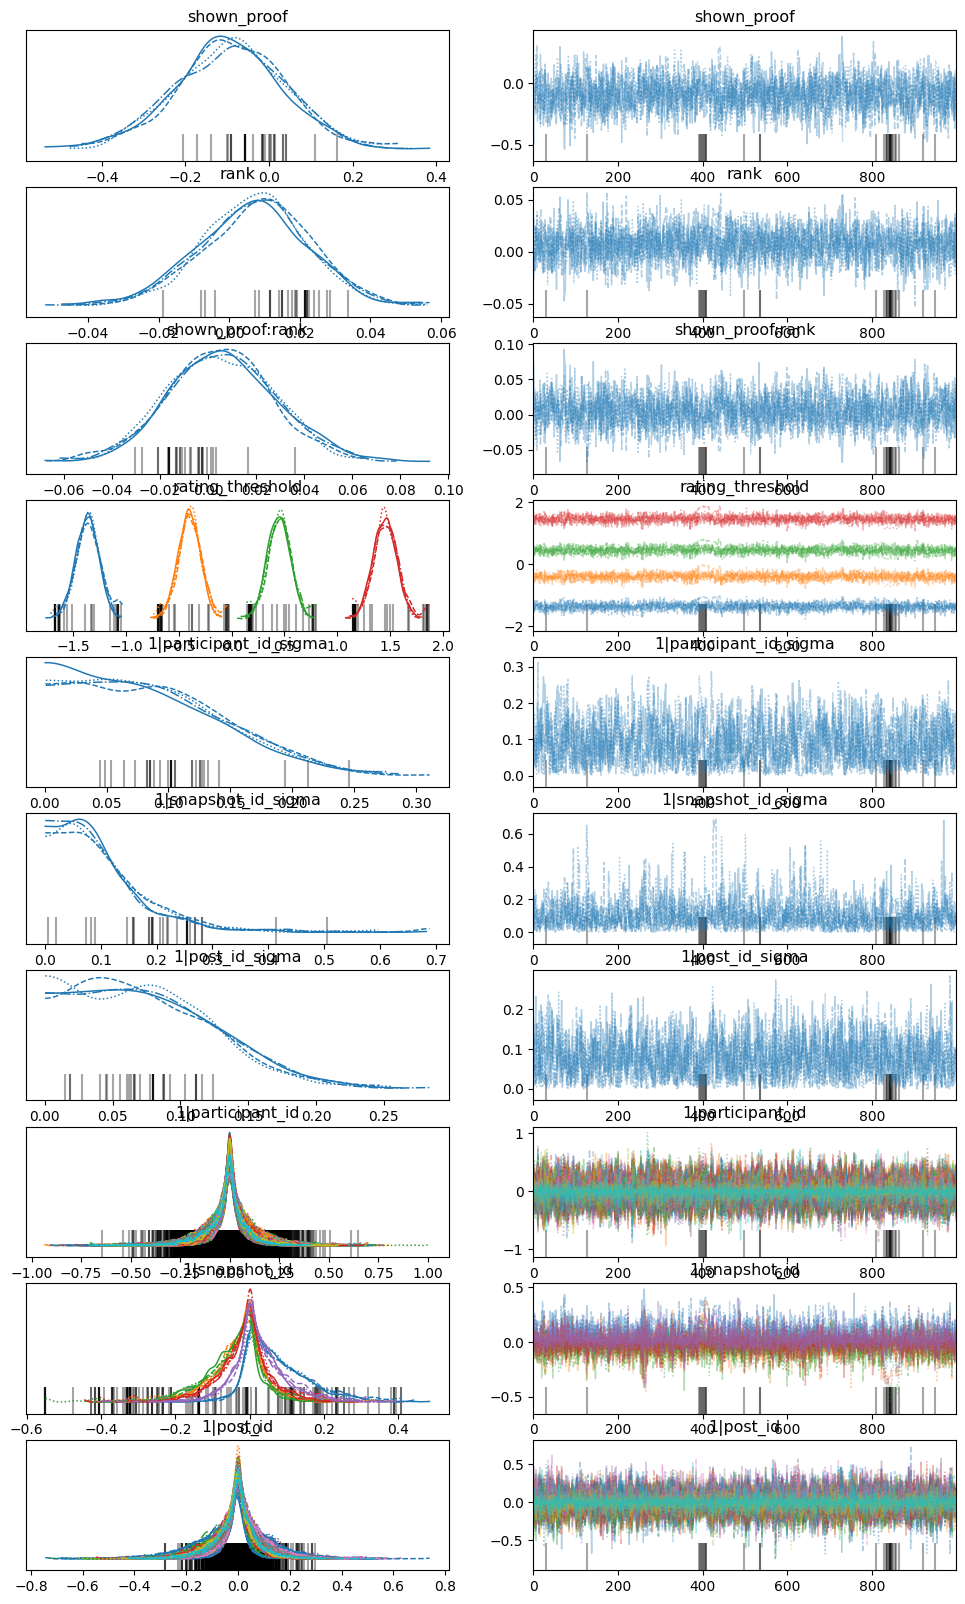

In [183]:
az.plot_trace(results)